In [1]:
import numpy as np
import scipy as sp
import scipy.linalg

from qiskit import  BasicAer, Aer, execute, assemble, QuantumCircuit, QuantumRegister
from qiskit.quantum_info.operators import Operator
backend = Aer.get_backend("qasm_simulator")

from utils import global_phase_gate, universal_ud

In [2]:
def hamiltonian_z(t,qc,qubits):

    for i in range(len(qubits)-1): qc.cx(qubits[i],qubits[i+1])

    qc.rz(-2*t,qubits[-1])

    for i in range(len(qubits)-1,0,-1): qc.cx(qubits[i-1],qubits[i])

def hamiltonian_pauli(arr,t,qc,qubits):

    new_arr,new_qub = [],[]

    for idx in range(len(arr)):
        if arr[idx] != 'I':
            new_arr.append(arr[idx])
            new_qub.append(qubits[idx])

    for i in range(len(new_arr)):
        if new_arr[i] == 'X': qc.h(new_qub[i])
        elif new_arr[i] == 'Y':
            # qc.s(new_qub[i])
            # qc.h(new_qub[i])
            qc.rx(np.pi/2,new_qub[i])
            
    hamiltonian_z(t,qc,new_qub)
    
    for i in range(len(new_arr)):
        if new_arr[i] == 'X': qc.h(new_qub[i])
        elif new_arr[i] == 'Y':
            # qc.h(new_qub[i])
            # qc.sdg(new_qub[i])
            qc.rx(-np.pi/2,new_qub[i])

def sim_hamiltonian(hamiltonian,t,qc,qubits,trotter=1):

    temp = QuantumCircuit(len(qubits))
    delta_t = t/trotter

    for pauli in hamiltonian: hamiltonian_pauli(pauli,hamiltonian[pauli]*delta_t,temp,range(len(qubits)))

    for i in range(trotter): qc.compose(temp,qubits,inplace=True)

    qc = qc.reverse_bits()
    return qc


In [3]:
M = (1/4)*np.array([[15, 9, 5,-3],
                    [ 9,15, 3,-5],
                    [ 5, 3,15,-9],
                    [-3,-5,-9,15]])

t = (1/8)*np.pi

U_A = np.eye(4, dtype='complex')
for i in range(1): U_A = sp.linalg.expm(1j*M*t)@U_A
print(np.round(U_A,3))

[[ 0.158+0.522j -0.658-0.022j -0.304-0.169j  0.196+0.331j]
 [-0.658-0.022j  0.158+0.522j -0.196-0.331j  0.304+0.169j]
 [-0.304-0.169j -0.196-0.331j  0.158+0.522j  0.658+0.022j]
 [ 0.196+0.331j  0.304+0.169j  0.658+0.022j  0.158+0.522j]]


[[ 0.158+0.522j -0.658-0.022j -0.304-0.169j  0.196+0.331j]
 [-0.658-0.022j  0.158+0.522j -0.196-0.331j  0.304+0.169j]
 [-0.304-0.169j -0.196-0.331j  0.158+0.522j  0.658+0.022j]
 [ 0.196+0.331j  0.304+0.169j  0.658+0.022j  0.158+0.522j]]
Hamiltonian simulation successful: True


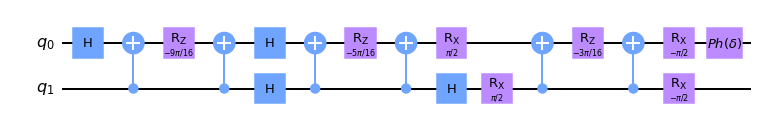

In [4]:
qc = QuantumCircuit(2)
phase = (15/4)*t

qc = sim_hamiltonian({"ZX": 9/4,"XZ": 5/4,"YY": 3/4},t,qc,[0,1],trotter=1)

global_phase_gate(qc,phase,0)

print(np.round(np.matrix(Operator(qc)),3))
print("Hamiltonian simulation successful:",np.allclose(np.matrix(Operator(qc)),U_A))
qc.draw('mpl')

[[ 0.158+0.522j -0.658-0.022j -0.304-0.169j  0.196+0.331j]
 [-0.658-0.022j  0.158+0.522j -0.196-0.331j  0.304+0.169j]
 [-0.304-0.169j -0.196-0.331j  0.158+0.522j  0.658+0.022j]
 [ 0.196+0.331j  0.304+0.169j  0.658+0.022j  0.158+0.522j]]
Unitary decomposition successful: True


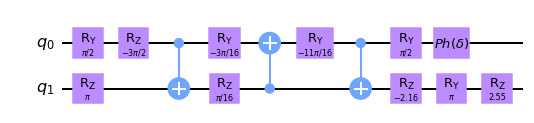

In [5]:
qc = QuantumCircuit(2)

phase = 0

phase = universal_ud(qc,U_A,range(2),phase)
global_phase_gate(qc,phase,0)

print(np.round(np.matrix(Operator(qc)),3))
print("Unitary decomposition successful:",np.allclose(np.matrix(Operator(qc)),U_A))
qc.draw('mpl')